# QAQC Plot for LARGEEE

Note: Change `table_name` in "Load Data" Section before running notebook (they are marked with TODO)

## Import modules

In [61]:
import pandas as pd
from pathlib import Path

# from buildstock_query import BuildStockQuery
import qaqc_helper

In [62]:
### Helper constants
NG_HEAT_CONTENT = (
    1034.0  # BTU/ft3 - https://www.eia.gov/dnav/ng/ng_cons_heat_a_EPG0_VGTH_btucf_a.htm
)
MBTU_TO_THERM = 10
KBTU_TO_THERM = 1e-2
MBTU_TO_KWH = 293.07107
KBTU_TO_KWH = 0.29307107
KBTU_TO_MBTU = 1e-3
MBTU_TO_TBTU = 1e-6
KWH_TO_MWH = 1e-3
KWH_TO_GWH = 1e-6


## Constants & Funcs

In [63]:
output_dir = Path(".").resolve() / "data" / "output"
output_dir.mkdir(parents=True, exist_ok=True)


## Download data

In [64]:
### run CLI to see what's available
!aws s3 ls largeee/test_runs/

                           PRE baseline_20230525/
                           PRE cateory_2_20230525/
                           PRE cateory_3_20230525/
                           PRE cateory_4_20230525/
                           PRE small_run_baseline_20230613/
2023-05-20 19:37:05          0 


In [65]:
table_name = "cateory_2_20230525" #"cateory_2_20230525" "baseline_20230525"# <---- TODO: specify table for download
s3_prefix = f"test_runs/{table_name}/" 

data_dir = qaqc_helper.s3_download.get_localdir_for_run(s3_prefix)
qaqc_helper.s3_download.download_s3_files(s3_prefix, destination=data_dir)

Data directory: C:\Users\ylou2\Desktop\resstock\docs\validation\data\cateory_2_20230525
C:\Users\ylou2\Desktop\resstock\docs\validation\data\cateory_2_20230525 files exist, no downloading


### Load

In [66]:
N_UNITS = 136569411
table_name = "cateory_2_20230525" # <--- folder containing upgrades only 
data_dir = qaqc_helper.s3_download.get_localdir_for_run(table_name)
baseline_data_dir = Path(".").resolve() / "data" / "baseline_20230525" # <--- TODO: make sure baseline is correct
print(f"baseline_data_dir: {baseline_data_dir}")

Data directory: C:\Users\ylou2\Desktop\resstock\docs\validation\data\cateory_2_20230525
baseline_data_dir: C:\Users\ylou2\Desktop\resstock\docs\validation\data\baseline_20230525


### Flag failure and invalid samples
Invalid means upgrades does not apply

In [67]:
dfb, DFU = qaqc_helper.load_process.load_baseline_and_upgrades(data_dir, baseline_data_dir=baseline_data_dir, success_only=True)
dfb


        Returned output is: 
            first output: baseline dataframe
            second output: dictionary of upgrade packages, with key = upgrade_name and value = upgrade dataframe
        
Baseline: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade Thin Triple Windows: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade EnergyStar Windows: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade Light Touch Envelope: completed_status
Fail          7
Invalid    1793
Success    8138
Name: building_id, dtype: int64
Upgrade Intermediate Envelope: completed_status
Fail          7
Invalid     322
Success    9609
Name: building_id, dtype: int64
Upgrade Advanced Enclosure: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64


,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,build_existing_model.applicable,...,report_utility_bills.bills_propane_fixed_usd,report_utility_bills.bills_propane_total_usd,report_utility_bills.bills_total_usd,report_utility_bills.bills_wood_cord_energy_usd,report_utility_bills.bills_wood_cord_fixed_usd,report_utility_bills.bills_wood_cord_total_usd,report_utility_bills.bills_wood_pellets_energy_usd,report_utility_bills.bills_wood_pellets_fixed_usd,report_utility_bills.bills_wood_pellets_total_usd,report_utility_bills.output_format
building_id,,,,,,,,,,,,,,,,,,,,,
1,1,2023-05-25 14:26:36,2023-05-25 14:26:50,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,2169.04,0.0,0.0,0.0,0.0,0.0,0.0,csv
2,1,2023-05-25 15:11:31,2023-05-25 15:11:44,Success,NaN,NaN,,Non-CBSA Pacific,No,True,...,0.0,0.0,3734.08,0.0,0.0,0.0,0.0,0.0,0.0,csv
3,1,2023-05-25 14:26:53,2023-05-25 14:27:05,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,1637.84,0.0,0.0,0.0,0.0,0.0,0.0,csv
4,1,2023-05-25 14:28:34,2023-05-25 14:28:45,Success,NaN,NaN,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,True,...,0.0,0.0,1037.90,0.0,0.0,0.0,0.0,0.0,0.0,csv
5,1,2023-05-25 15:09:40,2023-05-25 15:09:51,Success,NaN,NaN,,Non-CBSA South Atlantic,No,True,...,0.0,0.0,1991.22,0.0,0.0,0.0,0.0,0.0,0.0,csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,1,2023-05-25 15:32:20,2023-05-25 15:32:34,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,1835.94,0.0,0.0,0.0,0.0,0.0,0.0,csv
9997,1,2023-05-25 14:45:20,2023-05-25 14:45:35,Success,NaN,NaN,,Non-CBSA East South Central,No,True,...,0.0,0.0,2001.40,0.0,0.0,0.0,0.0,0.0,0.0,csv
9998,1,2023-05-25 15:07:33,2023-05-25 15:07:47,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,2221.43,0.0,0.0,0.0,0.0,0.0,0.0,csv


### Check fixed costs are being removed when a fuel is no longer being used

In [68]:
enduse_list = ['electricity','fuel_oil','natural_gas','propane','wood_cord','wood_pellets']
for enduse in enduse_list:
    Error = 0
    for row in range(1,len(dfb)):
        if dfb.iloc[row][f'report_simulation_output.fuel_use_{enduse}_total_m_btu'] == 0 and dfb.iloc[row][f'report_utility_bills.bills_{enduse}_fixed_usd'] !=0:
            Error += 1
    if Error > 0:
        print("Error: " + enduse)
    if Error == 0:
        print("Fixed costs are being removed when a fuel is no longer being used: "+enduse)

Fixed costs are being removed when a fuel is no longer being used: electricity
Fixed costs are being removed when a fuel is no longer being used: fuel_oil
Fixed costs are being removed when a fuel is no longer being used: natural_gas
Fixed costs are being removed when a fuel is no longer being used: propane
Fixed costs are being removed when a fuel is no longer being used: wood_cord
Fixed costs are being removed when a fuel is no longer being used: wood_pellets


### Results

#### 1. Upgrade costs

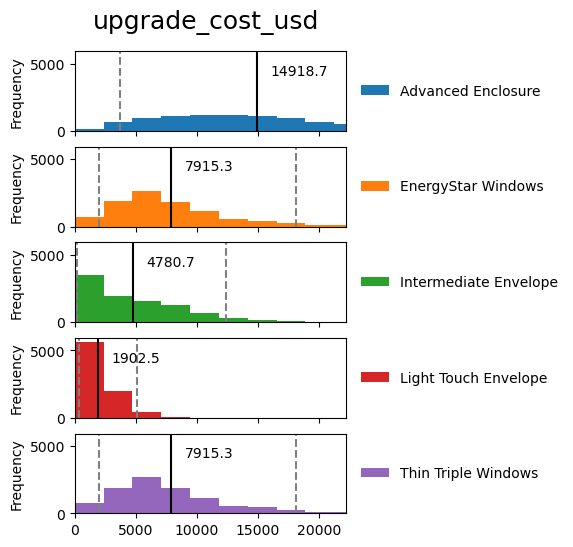

In [69]:
metric = "upgrade_costs.upgrade_cost_usd"
output_type = None
hc = ["upgrade"]
nbins = 50

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric, hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 2. Bill savings

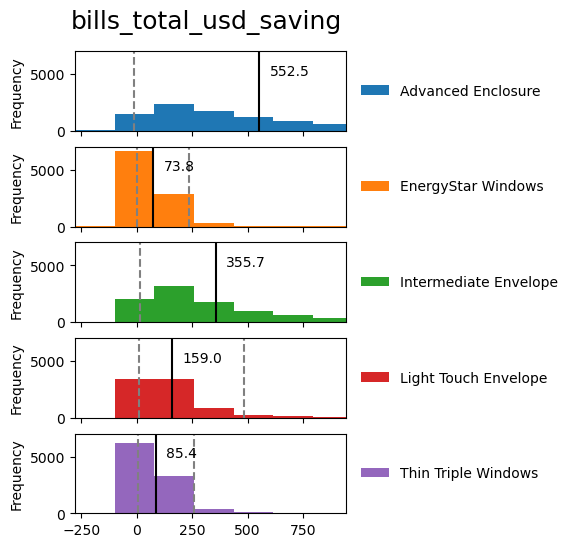

In [70]:
metric = "report_utility_bills.bills_total_usd"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 200

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

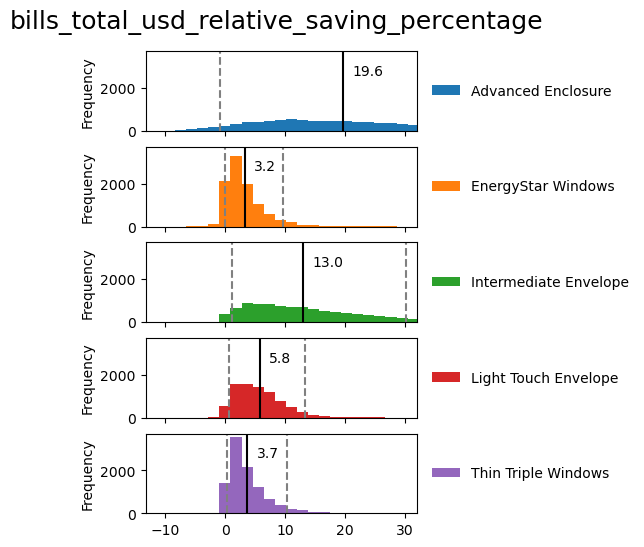

In [71]:
metric = "report_utility_bills.bills_total_usd"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 60

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 3. Emission savings

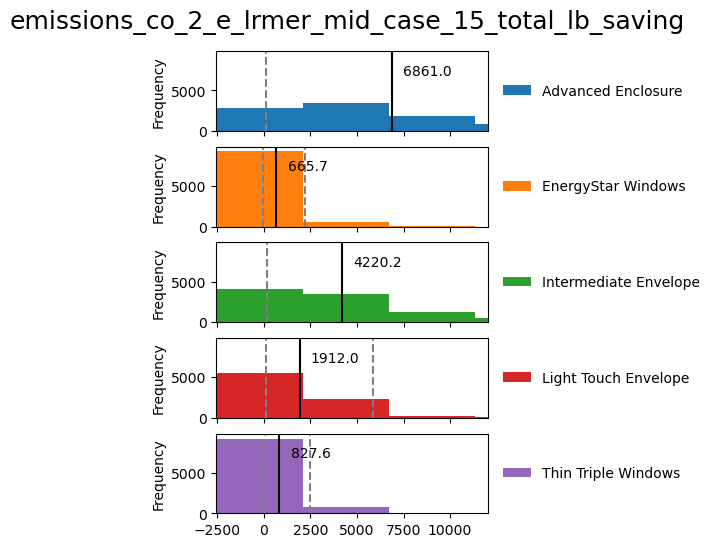

In [72]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 60

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

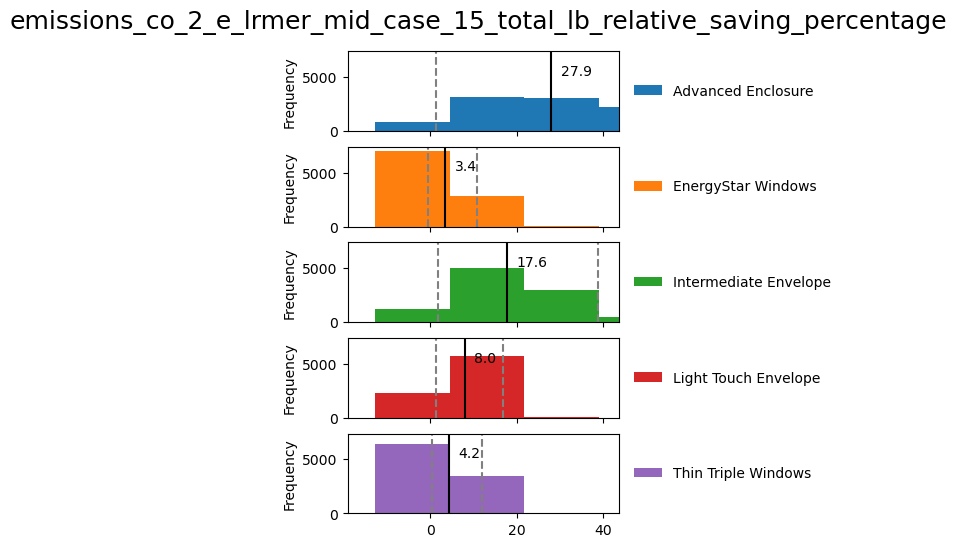

In [73]:
metric = "report_simulation_output.emissions_co_2_e_lrmer_mid_case_15_total_lb"
output_type = "relative_saving_percentage" # negative saving means net increase

hc = ["upgrade"] # "lmi", "tenure"
nbins = 60

dfs = qaqc_helper.load_process.get_upgrade_relative_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

#### 4. End use
Check end use with changes

In [81]:
metric_list = ['report_simulation_output.end_use_coal_clothes_dryer_m_btu',
 'report_simulation_output.end_use_coal_fireplace_m_btu',
 'report_simulation_output.end_use_coal_generator_m_btu',
 'report_simulation_output.end_use_coal_grill_m_btu',
 'report_simulation_output.end_use_coal_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_coal_heating_m_btu',
 'report_simulation_output.end_use_coal_hot_water_m_btu',
 'report_simulation_output.end_use_coal_lighting_m_btu',
 'report_simulation_output.end_use_coal_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_coal_range_oven_m_btu',
 'report_simulation_output.end_use_electricity_battery_m_btu',
 'report_simulation_output.end_use_electricity_ceiling_fan_m_btu',
 'report_simulation_output.end_use_electricity_clothes_dryer_m_btu',
 'report_simulation_output.end_use_electricity_clothes_washer_m_btu',
 'report_simulation_output.end_use_electricity_cooling_fans_pumps_m_btu',
 'report_simulation_output.end_use_electricity_cooling_m_btu',
 'report_simulation_output.end_use_electricity_dehumidifier_m_btu',
 'report_simulation_output.end_use_electricity_dishwasher_m_btu',
 'report_simulation_output.end_use_electricity_electric_vehicle_charging_m_btu',
 'report_simulation_output.end_use_electricity_freezer_m_btu',
 'report_simulation_output.end_use_electricity_generator_m_btu',
 'report_simulation_output.end_use_electricity_heating_fans_pumps_m_btu',
 'report_simulation_output.end_use_electricity_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_electricity_heating_m_btu',
 'report_simulation_output.end_use_electricity_hot_tub_heater_m_btu',
 'report_simulation_output.end_use_electricity_hot_tub_pump_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_recirc_pump_m_btu',
 'report_simulation_output.end_use_electricity_hot_water_solar_thermal_pump_m_btu',
 'report_simulation_output.end_use_electricity_lighting_exterior_m_btu',
 'report_simulation_output.end_use_electricity_lighting_garage_m_btu',
 'report_simulation_output.end_use_electricity_lighting_interior_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_precooling_m_btu',
 'report_simulation_output.end_use_electricity_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_electricity_plug_loads_m_btu',
 'report_simulation_output.end_use_electricity_pool_heater_m_btu',
 'report_simulation_output.end_use_electricity_pool_pump_m_btu',
 'report_simulation_output.end_use_electricity_pv_m_btu',
 'report_simulation_output.end_use_electricity_range_oven_m_btu',
 'report_simulation_output.end_use_electricity_refrigerator_m_btu',
 'report_simulation_output.end_use_electricity_television_m_btu',
 'report_simulation_output.end_use_electricity_well_pump_m_btu',
 'report_simulation_output.end_use_electricity_whole_house_fan_m_btu',
 'report_simulation_output.end_use_fuel_oil_clothes_dryer_m_btu',
 'report_simulation_output.end_use_fuel_oil_fireplace_m_btu',
 'report_simulation_output.end_use_fuel_oil_generator_m_btu',
 'report_simulation_output.end_use_fuel_oil_grill_m_btu',
 'report_simulation_output.end_use_fuel_oil_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_fuel_oil_heating_m_btu',
 'report_simulation_output.end_use_fuel_oil_hot_water_m_btu',
 'report_simulation_output.end_use_fuel_oil_lighting_m_btu',
 'report_simulation_output.end_use_fuel_oil_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_fuel_oil_range_oven_m_btu',
 'report_simulation_output.end_use_natural_gas_clothes_dryer_m_btu',
 'report_simulation_output.end_use_natural_gas_fireplace_m_btu',
 'report_simulation_output.end_use_natural_gas_generator_m_btu',
 'report_simulation_output.end_use_natural_gas_grill_m_btu',
 'report_simulation_output.end_use_natural_gas_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_natural_gas_heating_m_btu',
 'report_simulation_output.end_use_natural_gas_hot_tub_heater_m_btu',
 'report_simulation_output.end_use_natural_gas_hot_water_m_btu',
 'report_simulation_output.end_use_natural_gas_lighting_m_btu',
 'report_simulation_output.end_use_natural_gas_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_natural_gas_pool_heater_m_btu',
 'report_simulation_output.end_use_natural_gas_range_oven_m_btu',
 'report_simulation_output.end_use_propane_clothes_dryer_m_btu',
 'report_simulation_output.end_use_propane_fireplace_m_btu',
 'report_simulation_output.end_use_propane_generator_m_btu',
 'report_simulation_output.end_use_propane_grill_m_btu',
 'report_simulation_output.end_use_propane_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_propane_heating_m_btu',
 'report_simulation_output.end_use_propane_hot_water_m_btu',
 'report_simulation_output.end_use_propane_lighting_m_btu',
 'report_simulation_output.end_use_propane_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_propane_range_oven_m_btu',
 'report_simulation_output.end_use_wood_cord_clothes_dryer_m_btu',
 'report_simulation_output.end_use_wood_cord_fireplace_m_btu',
 'report_simulation_output.end_use_wood_cord_generator_m_btu',
 'report_simulation_output.end_use_wood_cord_grill_m_btu',
 'report_simulation_output.end_use_wood_cord_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_wood_cord_heating_m_btu',
 'report_simulation_output.end_use_wood_cord_hot_water_m_btu',
 'report_simulation_output.end_use_wood_cord_lighting_m_btu',
 'report_simulation_output.end_use_wood_cord_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_wood_cord_range_oven_m_btu',
 'report_simulation_output.end_use_wood_pellets_clothes_dryer_m_btu',
 'report_simulation_output.end_use_wood_pellets_fireplace_m_btu',
 'report_simulation_output.end_use_wood_pellets_generator_m_btu',
 'report_simulation_output.end_use_wood_pellets_grill_m_btu',
 'report_simulation_output.end_use_wood_pellets_heating_heat_pump_backup_m_btu',
 'report_simulation_output.end_use_wood_pellets_heating_m_btu',
 'report_simulation_output.end_use_wood_pellets_hot_water_m_btu',
 'report_simulation_output.end_use_wood_pellets_lighting_m_btu',
 'report_simulation_output.end_use_wood_pellets_mech_vent_preheating_m_btu',
 'report_simulation_output.end_use_wood_pellets_range_oven_m_btu']
output_type = "saving" # negative saving means net increase

dfs = qaqc_helper.load_process.get_upgrade_saving_list_dataframe(dfb, DFU, metric_list, output_type=output_type)
metric_list_new = [x + '_saving' for x in metric_list]
dfs = dfs[metric_list_new]    
temp = dfs.any()
temp = temp.to_frame()
temp.columns =["end_use_with_changes"]
temp.loc[temp["end_use_with_changes"] == True]

,end_use_with_changes
report_simulation_output.end_use_electricity_cooling_fans_pumps_m_btu_saving,True
report_simulation_output.end_use_electricity_cooling_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_fans_pumps_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_heat_pump_backup_m_btu_saving,True
report_simulation_output.end_use_electricity_heating_m_btu_saving,True
report_simulation_output.end_use_electricity_hot_water_m_btu_saving,True
report_simulation_output.end_use_electricity_mech_vent_m_btu_saving,True
report_simulation_output.end_use_fuel_oil_heating_m_btu_saving,True
report_simulation_output.end_use_fuel_oil_hot_water_m_btu_saving,True
report_simulation_output.end_use_natural_gas_heating_m_btu_saving,True


histogram for end use with changes

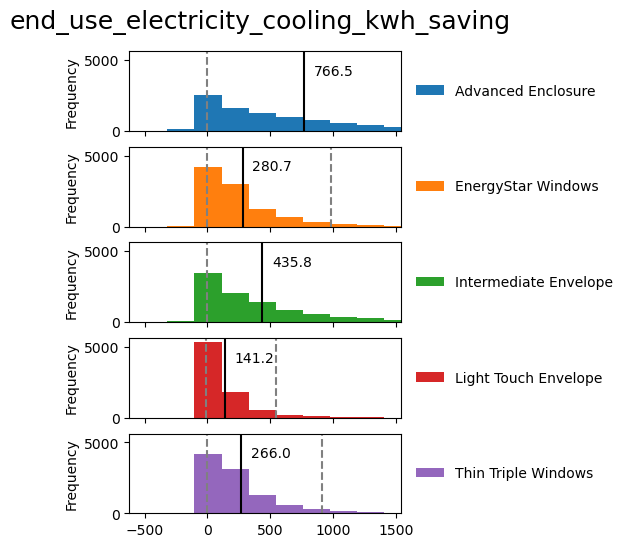

In [83]:
metric = "report_simulation_output.end_use_electricity_cooling_m_btu"
output_type = "saving" # negative saving means net increase

hc = ["upgrade"]
nbins = 60

dfs = qaqc_helper.load_process.get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)
qaqc_helper.plot.plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")